# Read Libraries

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics

#Light GBM
from fastai.tabular import * 

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

PATH = '/media/maria/2TB Monster driv/PrecisionFDA/'


In [2]:
from fastai.callbacks import *

# Read Data

In [3]:
train = pd.read_csv(PATH + 'Descriptive/train.csv')
test = pd.read_csv(PATH + 'Descriptive/test.csv')

In [4]:
#Remove death patients from the model
train = train.loc[train['Death Certification']!=1]

In [5]:
oof_df = train[["Id", "COVID_Status"]]

In [6]:
train.drop(columns=['Death', 'Hospitalized', 'Ventilator', 'ICU', 'Id', 
                    'Days_hospitalized', 'Days_ICU', 'Death Certification'], inplace=True)  

In [7]:
#Display all database

def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

In [8]:
display_all(train.describe())

DRIVERS  PASSPORT           LAT           LON  HEALTHCARE_EXPENSES  \
count  92742.0   92742.0  92742.000000  92742.000000         9.274200e+04   
mean       1.0       1.0     42.277104    -71.357391         1.010931e+06   
std        0.0       0.0      0.280791      0.596449         5.294289e+05   
min        1.0       1.0     41.241591    -73.490615         4.391440e+03   
25%        1.0       1.0     42.127232    -71.542817         6.256417e+05   
50%        1.0       1.0     42.317074    -71.154043         1.118774e+06   
75%        1.0       1.0     42.456085    -71.023419         1.450902e+06   
max        1.0       1.0     42.900027    -69.921561         3.203008e+06   

       HEALTHCARE_COVERAGE           Age  Allergy to bee venom  \
count         9.274200e+04  92742.000000           9215.000000   
mean          2.311168e+04     54.847157              0.186110   
std           5.976977e+04     18.414934              0.389216   
min           0.000000e+00     21.000000              0.000000   
25%           5.141960e+03     39.000000              0.000000   
50%           9.038375e+03     57.000000              0.000000   
75%           1.606873e+04     71.000000              0.000000   
max           1.557373e+06     84.000000              1.000000   

       Allergy to dairy product  Allergy to eggs  Allergy to fish  \
count               9215.000000      9215.000000      9215.000000   
mean                   0.037656         0.048182         0.176451   
std                    0.190373         0.214163         0.381224   
min                    0.000000         0.000000         0.000000   
25%                    0.000000         0.000000         0.000000   
50%                    0.000000         0.000000         0.000000   
75%                    0.000000         0.000000         0.000000   
max                    1.000000         1.000000         1.000000   

       Allergy to grass pollen  Allergy to mould  Allergy to nut  \
count              9215.000000       9215.000000     9215.000000   
mean                  0.268367          0.374498        0.176668   
std                   0.443134          0.484019        0.381409   
min                   0.000000          0.000000        0.000000   
25%                   0.000000          0.000000        0.000000   
50%                   0.000000          0.000000        0.000000   
75%                   1.000000          1.000000        0.000000   
max                   1.000000          1.000000        1.000000   

       Allergy to peanuts  Allergy to soya  Allergy to tree pollen  \
count         9215.000000      9215.000000             9215.000000   
mean             0.192946         0.016820                0.263266   
std              0.394633         0.128605                0.440430   
min              0.000000         0.000000                0.000000   
25%              0.000000         0.000000                0.000000   
50%              0.000000         0.000000                0.000000   
75%              0.000000         0.000000                1.000000   
max              1.000000         1.000000                1.000000   

       Allergy to wheat  Dander (animal) allergy  House dust mite allergy  \
count       9215.000000              9215.000000              9215.000000   
mean           0.044710                 0.345632                 0.260553   
std            0.206677                 0.475600                 0.438960   
min            0.000000                 0.000000                 0.000000   
25%            0.000000                 0.000000                 0.000000   
50%            0.000000                 0.000000                 0.000000   
75%            0.000000                 1.000000                 1.000000   
max            1.000000                 1.000000                 1.000000   

       Latex allergy  Shellfish allergy  Agreeing on diabetes care plan  \
count    9215.000000        9215.000000                    84917.000000   
mean    

# Training Neural Network 

In [9]:
procs = [FillMissing, Categorify, Normalize]

In [10]:
dep_var = 'COVID_Status'
cat_names = ['DRIVERS' , 'PASSPORT', 'MARITAL', 'RACE', 'ETHNICITY',
             'GENDER', 'COUNTY', 'PLACE_BIRTH']

In [11]:
PATH_data = PATH + 'Descriptive/'

In [12]:
#https://www.kaggle.com/dromosys/fast-ai-v1-focal-loss

from torch import nn
import torch.nn.functional as F

#Parameters of focal loss

class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=5, logits=False, reduction='elementwise_mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.reduction = reduction

    def forward(self, inputs, targets):
        if self.logits:
            BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        else:
            BCE_loss = F.binary_cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduction is None:
            return F_loss
        else:
            return torch.mean(F_loss)

In [13]:
# Setting random seed

SEED = 2019

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    #tf.set_random_seed(seed)
seed_everything(SEED)


In [14]:
def auroc_score(input, target):
    input, target = input.cpu().numpy()[:,1], target.cpu().numpy()
    return roc_auc_score(target, input)

class AUROC(Callback):
    _order = -20 #Needs to run before the recorder

    def __init__(self, learn, **kwargs): self.learn = learn
    def on_train_begin(self, **kwargs): self.learn.recorder.add_metric_names(['AUROC'])
    def on_epoch_begin(self, **kwargs): self.output, self.target = [], []
    
    def on_batch_end(self, last_target, last_output, train, **kwargs):
        if not train:
            self.output.append(last_output)
            self.target.append(last_target)
                
    def on_epoch_end(self, last_metrics, **kwargs):
        if len(self.output) > 0:
            output = torch.cat(self.output)
            target = torch.cat(self.target)
            preds = F.softmax(output, dim=1)
            metric = auroc_score(preds, target)
            return add_metrics(last_metrics,[metric])

In [15]:
len(test)

29492

In [16]:
#5 Fold cross-validation
nfold = 5
target = 'COVID_Status'
skf = KFold(n_splits=nfold, shuffle=True, random_state=2019)

oof = np.zeros(len(train))
predictions = np.zeros(len(test))

In [17]:
train['COVID_Status'].describe()

count    92742.000000
mean         0.794645
std          0.403963
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: COVID_Status, dtype: float64

In [18]:
test.shape

(29492, 938)

In [19]:
dep_var

'COVID_Status'


fold 1


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


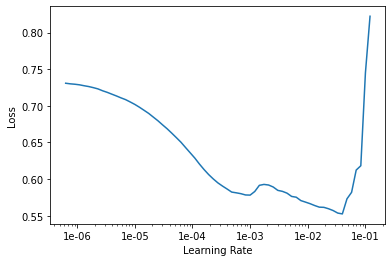

In [20]:
#Find Learning Rate
i = 1
cont_names = set(train) - set(cat_names) - {dep_var}

for train_index, valid_idx in skf.split(train, train.COVID_Status.values):
    if i>1: 
        break
    print("\nfold {}".format(i))
    
    data= (TabularList.from_df(train, path=PATH_data, cat_names=cat_names, cont_names= cont_names, procs=procs)
                .split_by_idx(valid_idx)
                .label_from_df(cols=dep_var)
                .databunch(bs=4096))
    
    
    learn = tabular_learner(data, layers=[3600, 1800], emb_drop=0.05, metrics=accuracy) #like rossmann
    #learn.loss_fn = FocalLoss()
    
    learn.lr_find()
    learn.recorder.plot()
    i=i+1


In [21]:
'COVID_Status' in cont_names

False

In [22]:
i = 1
lr = 2e-3

for train_index, valid_idx in skf.split(train, train.COVID_Status.values):
    print("\nfold {}".format(i))
    
    
    data = (TabularList.from_df(train, path=PATH_data, cat_names=cat_names, cont_names= cont_names, procs=procs)
                .split_by_idx(valid_idx)
                .label_from_df(cols=dep_var)
                .add_test(TabularList.from_df(test, path=PATH_data, cat_names=cat_names, cont_names= cont_names))
                .databunch(bs=4096))
    
    learn = tabular_learner(data, layers=[3600, 1800], emb_drop=0.05, metrics=accuracy) #like rossmann
    #learn.loss_fn = FocalLoss()
    
    learn.fit_one_cycle(15, slice(lr), callbacks=[AUROC(learn),
                                               SaveModelCallback(learn, every='improvement',
                                              monitor='valid_loss', name='bestmodel_fold{}'.format(i))], wd=0.1)
    learn.load('bestmodel_fold{}'.format(i))
    interp = ClassificationInterpretation.from_learner(learn)
    from sklearn import metrics
    print(metrics.classification_report(interp.y_true.numpy(), interp.pred_class.numpy()))

    preds_valid = learn.get_preds(ds_type=DatasetType.Valid)
    predictions_v = []

    for j in range(len(valid_idx)):
        predictions_v.append(float(preds_valid[0][j][1].cpu().numpy()))
    
    oof[valid_idx] = predictions_v 
    
    preds = learn.get_preds(ds_type=DatasetType.Test)
    
    predictions_t = []

    for j in range(test.shape[0]):
        predictions_t.append(float(preds[0][j][1].cpu().numpy()))

    
    predictions += predictions_t 
    i = i + 1


fold 1


epoch,train_loss,valid_loss,accuracy,AUROC,time
0,0.521947,84.314415,0.832767,0.691702,00:06
1,0.461207,115.526619,0.836325,0.685285,00:06
2,0.421370,10.092659,0.862526,0.696622,00:06
3,0.398958,0.443373,0.864844,0.694590,00:06
4,0.379294,0.475069,0.859992,0.687697,00:06
5,0.363290,0.470840,0.855464,0.691986,00:06
6,0.343809,25550.253906,0.853847,0.697175,00:06
7,0.321284,0.528771,0.846515,0.693048,00:06
8,0.292659,0.565163,0.838644,0.693862,00:06
9,0.261661,19453.333984,0.839075,0.696254,00:06


Better model found at epoch 0 with valid_loss value: 84.31441497802734.
Better model found at epoch 2 with valid_loss value: 10.092658996582031.
Better model found at epoch 3 with valid_loss value: 0.44337254762649536.


              precision    recall  f1-score   support

           0       0.93      0.37      0.53      3810
           1       0.86      0.99      0.92     14739

    accuracy                           0.86     18549
   macro avg       0.89      0.68      0.73     18549
weighted avg       0.87      0.86      0.84     18549




fold 2


epoch,train_loss,valid_loss,accuracy,AUROC,time
0,0.511931,84.755081,0.849642,0.679082,00:06
1,0.451416,164.632736,0.839560,0.684630,00:06
2,0.412903,0.430448,0.860262,0.684435,00:06
3,0.390297,0.470552,0.857944,0.684637,00:06
4,0.374522,0.450914,0.854655,0.682638,00:06
5,0.357006,5065.793457,0.854493,0.685288,00:06
6,0.339338,0.512861,0.841717,0.681140,00:06
7,0.318452,0.517923,0.837619,0.682003,00:06
8,0.290991,8397.128906,0.843873,0.686934,00:06
9,0.258814,5760.671387,0.841663,0.677903,00:06


Better model found at epoch 0 with valid_loss value: 84.75508117675781.
Better model found at epoch 2 with valid_loss value: 0.43044784665107727.


              precision    recall  f1-score   support

           0       0.90      0.36      0.52      3826
           1       0.86      0.99      0.92     14723

    accuracy                           0.86     18549
   macro avg       0.88      0.68      0.72     18549
weighted avg       0.87      0.86      0.84     18549




fold 3


epoch,train_loss,valid_loss,accuracy,AUROC,time
0,0.507723,0.490853,0.829793,0.682071,00:06
1,0.456000,74.093315,0.839659,0.675943,00:06
2,0.417086,132.309036,0.859931,0.682754,00:06
3,0.393238,0.446003,0.859392,0.685201,00:06
4,0.375437,0.453142,0.854540,0.688221,00:06
5,0.358061,11170.810547,0.855941,0.678882,00:07
6,0.341143,16907.966797,0.850873,0.682864,00:06
7,0.317697,16280.814453,0.837017,0.680271,00:06
8,0.290264,13279.762695,0.835454,0.688020,00:06
9,0.257777,15114.500000,0.841061,0.687374,00:06


Better model found at epoch 0 with valid_loss value: 0.4908525347709656.
Better model found at epoch 3 with valid_loss value: 0.4460028111934662.


              precision    recall  f1-score   support

           0       0.91      0.35      0.51      3832
           1       0.85      0.99      0.92     14716

    accuracy                           0.86     18548
   macro avg       0.88      0.67      0.71     18548
weighted avg       0.87      0.86      0.83     18548




fold 4


epoch,train_loss,valid_loss,accuracy,AUROC,time
0,0.580278,19.039625,0.856211,0.700056,00:06
1,0.491393,253.325394,0.842948,0.688044,00:06
2,0.442170,456.083466,0.860201,0.696630,00:06
3,0.408003,1740.862915,0.860686,0.696880,00:06
4,0.387342,210.807129,0.858098,0.688108,00:06
5,0.368481,283.199951,0.852329,0.688964,00:06
6,0.346040,934.319153,0.855294,0.690944,00:06
7,0.322322,7434.357422,0.843757,0.693211,00:06
8,0.295387,3126.937988,0.844026,0.690769,00:06
9,0.263737,10162.759766,0.831950,0.691148,00:06


Better model found at epoch 0 with valid_loss value: 19.03962516784668.


              precision    recall  f1-score   support

           0       0.83      0.38      0.53      3853
           1       0.86      0.98      0.92     14695

    accuracy                           0.86     18548
   macro avg       0.85      0.68      0.72     18548
weighted avg       0.85      0.86      0.83     18548




fold 5


epoch,train_loss,valid_loss,accuracy,AUROC,time
0,0.490812,0.482553,0.851844,0.677847,00:06
1,0.440916,0.451292,0.854701,0.672027,00:06
2,0.406977,0.428731,0.858853,0.686764,00:06
3,0.389006,0.448910,0.863220,0.686359,00:06
4,0.379016,0.438902,0.860147,0.676547,00:06
5,0.361069,0.453180,0.854162,0.676015,00:06
6,0.341670,0.465030,0.848501,0.684964,00:06
7,0.318913,0.497063,0.836424,0.682938,00:06
8,0.292614,0.562108,0.845805,0.685992,00:06
9,0.263224,0.607678,0.830710,0.682443,00:06


Better model found at epoch 0 with valid_loss value: 0.4825526177883148.
Better model found at epoch 1 with valid_loss value: 0.4512917697429657.
Better model found at epoch 2 with valid_loss value: 0.42873114347457886.


              precision    recall  f1-score   support

           0       0.87      0.35      0.50      3724
           1       0.86      0.99      0.92     14824

    accuracy                           0.86     18548
   macro avg       0.86      0.67      0.71     18548
weighted avg       0.86      0.86      0.83     18548



In [23]:
print("\n\nCV AUC: {:<0.5f}".format(metrics.roc_auc_score(train.COVID_Status.values.astype(bool), oof)))
print("\n\nCV log loss: {:<0.5f}".format(metrics.log_loss(train.COVID_Status.values.astype(bool), oof)))
print("\n\nCV Gini: {:<0.5f}".format(2 * metrics.roc_auc_score(train.COVID_Status.values.astype(bool), oof) -1))



CV AUC: 0.68683


CV log loss: 0.45203


CV Gini: 0.37366


In [24]:
#threshold optimization

maximum = 0
for i in range(1000):
    f1 = metrics.f1_score(train.COVID_Status.values.astype(bool), oof >i*.001)
    if f1 > maximum:
        maximum=f1
        threshold =  i*0.001

print(f'Maximum f1 value: {maximum}' , f'Probability cutoff: {threshold}' )

Maximum f1 value: 0.9225738555213111 Probability cutoff: 0.034


In [25]:
print(metrics.classification_report(train.COVID_Status.values.astype(bool), oof >threshold))

              precision    recall  f1-score   support

       False       0.99      0.35      0.52     19045
        True       0.86      1.00      0.92     73697

    accuracy                           0.87     92742
   macro avg       0.92      0.68      0.72     92742
weighted avg       0.88      0.87      0.84     92742



# Explanations

In [26]:
pred = oof

In [27]:
#code from https://forums.fast.ai/t/feature-importance-in-deep-learning/42026/6
def feature_importance(learner, cat_names, cont_names): 
  # based on: https://medium.com/@mp.music93/neural-networks-feature-importance-with-fastai-5c393cf65815
    loss0=np.array([learner.loss_func(learner.pred_batch(batch=(x,y.to("cpu"))), y.to("cpu")) for x,y in iter(learner.data.valid_dl)]).mean()
    fi=dict()
    types=[cat_names, cont_names]
    for j, t in enumerate(types):
        for i, c in enumerate(t):
            loss=[]
            for x,y in iter(learner.data.valid_dl):
                col=x[j][:,i]    #x[0] da hier cat-vars
                idx = torch.randperm(col.nelement())
                x[j][:,i] = col.view(-1)[idx].view(col.size())
                y=y.to('cpu')
                loss.append(learner.loss_func(learner.pred_batch(batch=(x,y)), y))
            fi[c]=np.array(loss).mean()-loss0
    d = sorted(fi.items(), key=lambda kv: kv[1], reverse=True)
    return pd.DataFrame({'cols': [l for l, v in d], 'imp': np.log1p([v for l, v in d])})

In [28]:
imp = feature_importance(learn, cat_names, cont_names)

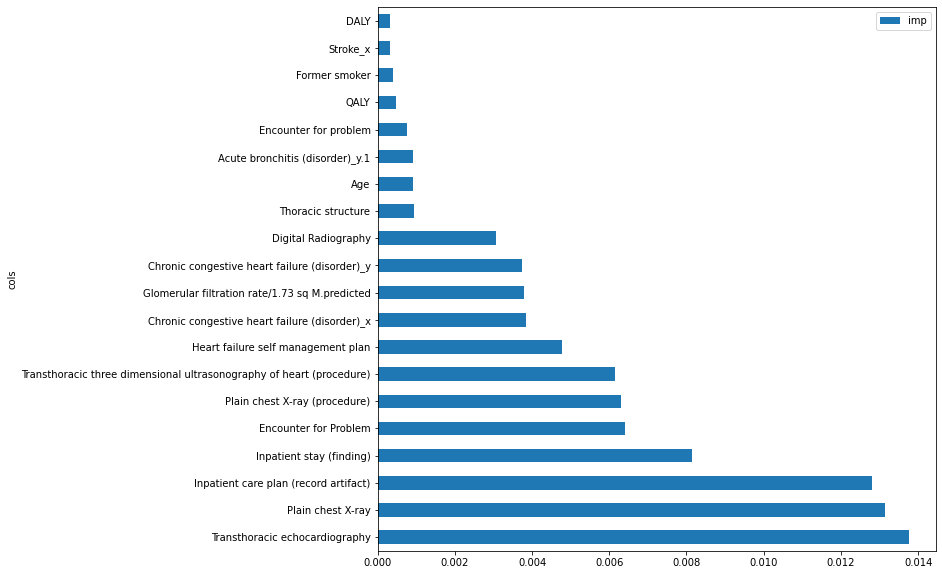

In [29]:
imp[:20].plot.barh(x="cols", y="imp", figsize=(10, 10))

In [30]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

In [31]:
fpr_rf, tpr_rf, _ = roc_curve(train.COVID_Status.values.astype(bool), oof)

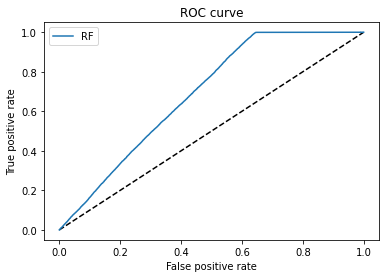

In [32]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()


In [33]:
sub_df = pd.read_csv(PATH + 'Descriptive/test.csv')
sub_df["COVID_Status"] = predictions/nfold

#If death all probabilities 0
sub_df["COVID_Status"][sub_df['Death Certification'] == 1] = 0

sub_df[['Id', 'COVID_Status']].to_csv("NN_Covid_status.csv", index=False, line_terminator='\n', header=False)


/home/maria/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [34]:
np.mean(sub_df["COVID_Status"]/nfold)

0.1168162266164989

#  No COVID

In [35]:
pd.DataFrame(sub_df['Id']).loc[sub_df["COVID_Status"]<threshold].to_csv("no_covid_predicted.csv", index=False)